In [1]:
import sys
sys.path.append('../xmen/benchmarks')

# Entity Simplification with OpenAI / GPT-4

In [2]:
from pathlib import Path
import pandas as pd
import datasets
import numpy as np

In [3]:
base_path = Path.home() / '.cache' / 'xmen' / 'symptemist'

In [4]:
import dataloaders
dataset = dataloaders.load_symptemist()[0]

In [5]:
from xmen import load_kb
kb = load_kb(base_path / 'symptemist.jsonl')

In [6]:
from xmen.evaluation import error_analysis, evaluate, evaluate_at_k

In [7]:
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / 'index')

/home/Florian.Borchert/miniconda3/envs/symptemist/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Florian.Borchert/miniconda3/envs/symptemist/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[02/27/24 17:40:22] INFO     Loading hierarchical faiss index                                ]8;id=148091;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=155522;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=674049;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=24089;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/symptemist/index/sapbert/embed_                    
                             faiss_hier.pickle                                                                     

[02/27/24 17:40:24] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=441220;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=516902;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 1079623                                                                          

In [8]:
SYMPTEMIST_FEW_SHOT_EXAMPLES = [
    ("afebril", "temperatura corporal normal"),
    ("induración de la vaginal testicular", "trastorno de testículo"),
    ("formaciones mamelonadas en su interior a nivel de lóbulo superior", "lesión de pulmón"),
    ("disnea", "disnea"),
]

In [9]:
def count_differences(simplified, original):
    cnt_all = 0
    cnt_diff = 0
    for ds, do in zip(simplified, original):
        for es, eo in zip(ds['entities'], do['entities']):
            cnt_all += 1
            if es['text'] != eo['text']:
                cnt_diff +=1
    return cnt_diff, cnt_all

In [10]:
MODEL = 'gpt-4-0125-preview'
# Pre-computed for SympTEMIST to save API calls
table_file = 'lookup_gpt-4-0125-preview_20240214-205237_prompt1.pkl'
prompt = SYMPTEMIST_FEW_SHOT_EXAMPLES

lookup_table = {}

In [11]:
import pickle
lookup_table = pickle.load(open(table_file, 'rb')) 

In [12]:
from xmen.data.simplification import GPTSimplifier, EntitySimplification, SimplifierWrapper

In [13]:
text_simplifier = GPTSimplifier(
    model=MODEL, 
    open_ai_api_key="insert_api_key", 
    fixed_few_shot_examples = prompt,
    table=lookup_table
)

In [14]:
simplifier = EntitySimplification(text_simplifier, set_long_form=True)

In [15]:
print(text_simplifier.prompt_template.format('aumento de densidad en lóbulo inferior'))

Your task is to simplify expressions, such that the simplified version is more suitable for looking up concepts in a medical terminology. If the input is already simple enough, just return the input. 

Here are some examples:
Input: ```afebril```
Simplified: ```temperatura corporal normal```

Input: ```induración de la vaginal testicular```
Simplified: ```trastorno de testículo```

Input: ```formaciones mamelonadas en su interior a nivel de lóbulo superior```
Simplified: ```lesión de pulmón```

Input: ```disnea```
Simplified: ```disnea```

Input: ```aumento de densidad en lóbulo inferior```
Simplified:


In [16]:
text_simplifier.simplify('aumento de densidad en lóbulo inferior')

'lesión de pulmón'

# Generate Candidates

In [17]:
candidates = linker.predict_batch(dataset, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [18]:
_ = evaluate_at_k(dataset['train'], candidates['train'])

Recall@1 0.4388426128890837
Recall@2 0.5610112523746895
Recall@4 0.6226801110623995
Recall@8 0.6786497150372643
Recall@16 0.7219055969603975
Recall@32 0.7558088557650153
Recall@64 0.7837205903843344


In [19]:
_ = evaluate_at_k(dataset['validation'], candidates['validation'])

Recall@1 0.4647592463363573
Recall@2 0.5757152826238661
Recall@4 0.6427076064200977
Recall@8 0.6929518492672715
Recall@16 0.7264480111653873
Recall@32 0.7571528262386602
Recall@64 0.782274947662247


In [20]:
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.4474885844748858
Recall@2 0.5602388479100808
Recall@4 0.6199508254302775
Recall@8 0.6656129258868985
Recall@16 0.7007376185458377
Recall@32 0.7323498419388831
Recall@64 0.7632595714787496


In [21]:
simplified_ds = simplifier.transform_batch(candidates)
simplified_candidates = linker.predict_batch(simplified_ds, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

# Determine Optimal Cutoff

In [22]:
SPLIT = 'train'
eval_candidates = candidates[SPLIT]
eval_ds = dataset[SPLIT]
eval_simplified_ds = simplified_candidates[SPLIT]

def select_candidates(d, idx, filter_fn=lambda e: True):
    result = []
    for ei, ec in zip(d['entities'], eval_candidates[idx]['entities']):
        if filter_fn(ec):
            result.append(ec)
        else:
            result.append(ei)
    return { 'entities' : result }

In [23]:
baseline = evaluate_at_k(eval_ds, eval_candidates, silent=True)

In [24]:
cutoff_eval = []

for cutoff in np.arange(0.55, 1.05, 0.05):
    print(cutoff)
    fn = lambda e: e['normalized'][0]['score'] >= cutoff
    best_candidates = eval_simplified_ds.map(lambda d, i: select_candidates(d, i, fn), with_indices=True)
    diffs = count_differences(best_candidates, eval_candidates)
    print(diffs)
    eval_res = evaluate_at_k(eval_ds, best_candidates, silent=True)
    cutoff_eval_i = {'cutoff' : cutoff, 'num_changed' : diffs[0], 'num_all' : diffs[1]}
    for i, es in eval_res.items():
        cutoff_eval_i[i] = es['strict']['recall']
    cutoff_eval.append(cutoff_eval_i)

0.55
(9, 6843)
0.6000000000000001
(104, 6843)
0.6500000000000001
(469, 6843)
0.7000000000000002
(1091, 6843)
0.7500000000000002
(1871, 6843)
0.8000000000000003
(2586, 6843)
0.8500000000000003
(3239, 6843)
0.9000000000000004
(3864, 6843)
0.9500000000000004
(4357, 6843)
1.0000000000000004
(5841, 6843)


In [25]:
cutoff_eval = pd.DataFrame(cutoff_eval).round(3)

In [26]:
cutoff_eval

,cutoff,num_changed,num_all,1,2,4,8,16,32,64
0,0.55,9,6843,0.439,0.561,0.623,0.679,0.722,0.756,0.784
1,0.60,104,6843,0.439,0.561,0.623,0.678,0.722,0.756,0.784
2,0.65,469,6843,0.442,0.565,0.626,0.681,0.726,0.760,0.789
3,0.70,1091,6843,0.449,0.572,0.635,0.688,0.733,0.768,0.796
4,0.75,1871,6843,0.451,0.577,0.640,0.694,0.738,0.773,0.802
5,0.80,2586,6843,0.453,0.577,0.638,0.692,0.739,0.773,0.803
6,0.85,3239,6843,0.453,0.575,0.638,0.694,0.747,0.781,0.811
7,0.90,3864,6843,0.446,0.568,0.635,0.691,0.745,0.781,0.811
8,0.95,4357,6843,0.433,0.556,0.627,0.686,0.743,0.781,0.810
9,1.00,5841,6843,0.428,0.552,0.623,0.686,0.743,0.781,0.810


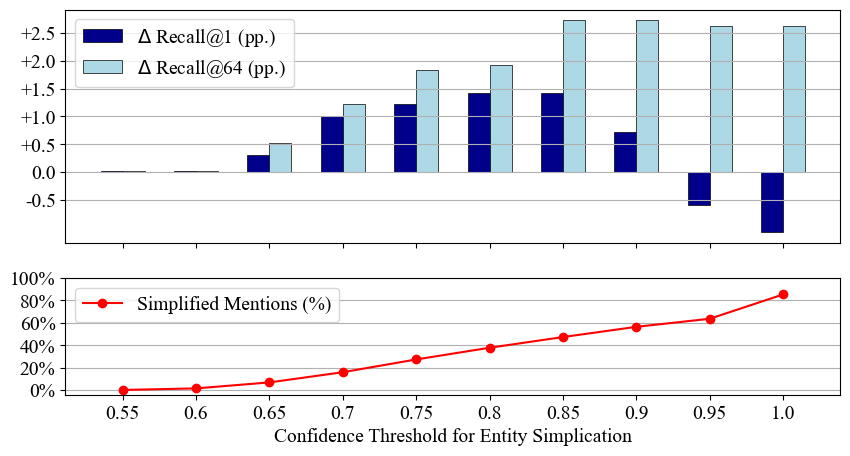

In [27]:
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 14, 'font.family' : 'Times New Roman'})

fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, squeeze=True)

ax1 = axs[0]

x_range = np.arange(0, len(cutoff_eval))
width = 0.3       

ax1.bar(x_range - 0.5 * width, 
        (cutoff_eval.set_index('cutoff')[1] - baseline[1]['strict']['recall']).values, 
        width, color='darkblue', linewidth=0.5, edgecolor='black', label='$\Delta$ Recall@1 (pp.)')
ax1.bar(x_range + 0.5 * width, 
        (cutoff_eval.set_index('cutoff')[64] - baseline[64]['strict']['recall']).values, 
        width, color='lightblue', linewidth=0.5, edgecolor='black', label='$\Delta$ Recall@64 (pp.)')

ax1.grid(axis='y')
ax1.set_yticks(np.arange(-0.005, 0.03, 0.005))
ax1.set_yticklabels([f'+{t * 100:.1f}' if t > 0 else f'{t * 100:.1f}' for t in ax1.get_yticks()])

ax1.set_xticks(x_range)
ax1.set_xticklabels(cutoff_eval.cutoff.values)

ax0 = axs[1]
ax0.grid(axis='y')
ax0.plot(x_range, cutoff_eval.num_changed / cutoff_eval.num_all, color='red', label='Simplified Mentions (%)', marker='o')
ax0.set_yticks(np.arange(0,1.02,0.2))
ax0.set_yticklabels([f"{int(t * 100)}%" if t >= 0 and t <=1 else "" for t in ax0.get_yticks()])

ax0.set_xlabel('Confidence Threshold for Entity Simplication')
ax0.legend()

ax0.set_xticks(x_range)
ax0.set_xticklabels(cutoff_eval.cutoff.values)

ax1.legend()

#plt.savefig('diff_cutoff.png', dpi=1200, bbox_inches='tight')

plt.show()

In [28]:
best_cutoff = 0.85

In [29]:
# we use a SimplifierWrapper so that the original spans can be restored after candidate generatio
simplifier_wrapper = SimplifierWrapper(
    linker,
    text_simplifier, 
    filter_fn=lambda c: c['normalized'][0]['score'] < best_cutoff, 
    set_long_form=True
)
simplified_candidates_cutoff = simplifier_wrapper.predict_batch(candidates, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [30]:
print(count_differences(simplified_candidates_cutoff['train'], dataset['train']))
print(count_differences(simplified_candidates_cutoff['validation'], dataset['validation']))
print(count_differences(simplified_candidates_cutoff['test'], dataset['test']))

(0, 6843)
(0, 1433)
(0, 2848)


In [31]:
_ = evaluate_at_k(dataset['validation'], simplified_candidates_cutoff['validation'])

Recall@1 0.48499651081646894
Recall@2 0.5903698534542917
Recall@4 0.6566643405443127
Recall@8 0.7083042568039079
Recall@16 0.7522679692951849
Recall@32 0.7773900907187719
Recall@64 0.8066992323796232


In [32]:
_ = evaluate_at_k(dataset['test'], simplified_candidates_cutoff['test'])

Recall@1 0.46224095539164034
Recall@2 0.5760449596066034
Recall@4 0.6434843695117668
Recall@8 0.6880927291886196
Recall@16 0.7288373726729891
Recall@32 0.7629083245521602
Recall@64 0.794169301018616


# Save

In [33]:
#simplified_candidates_cutoff.save_to_disk('candidates_simplified_cutoff')

# Analysis

In [34]:
from xmen.evaluation import error_analysis, evaluate_at_k

In [35]:
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.4474885844748858
Recall@2 0.5602388479100808
Recall@4 0.6199508254302775
Recall@8 0.6656129258868985
Recall@16 0.7007376185458377
Recall@32 0.7323498419388831
Recall@64 0.7632595714787496


In [36]:
_ = evaluate_at_k(dataset['test'], simplified_candidates_cutoff['test'])

Recall@1 0.46224095539164034
Recall@2 0.5760449596066034
Recall@4 0.6434843695117668
Recall@8 0.6880927291886196
Recall@16 0.7288373726729891
Recall@32 0.7629083245521602
Recall@64 0.794169301018616


In [37]:
simplified_ds = simplifier.transform_batch(dataset)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [38]:
ea_before_simpl = error_analysis(dataset['train'], candidates['train'])
ea_after_simple = error_analysis(simplified_ds['train'], simplified_candidates_cutoff['train'])

In [39]:
index = []
labels = []
match_any = []
match_lost = []
better_ranking = []
worse_ranking = []
n_candidates = []

end = 10

def get_new_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index != -1)]

def get_better_ranking(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_after_simple.pred_index != -1) & (ea_after_simple.pred_index < ea_before_simpl.pred_index)]

def get_worse_ranking(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index != -1) & (ea_after_simple.pred_index > ea_before_simpl.pred_index)]

def get_lost_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index != -1) & (ea_after_simple.pred_index == -1)]

def get_n_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i)]

for i in range(1, end + 1):
    n_candidates_i = get_n_candidates(i)
    eaany = get_new_candidates(i)
    eabetter = get_better_ranking(i)
    ealost = get_lost_candidates(i)
    eaworse = get_worse_ranking(i)
    
    n_candidates.append(len(n_candidates_i))
    index.append(i)
    labels.append(str(i))
    match_any.append(len(eaany))
    better_ranking.append(len(eabetter))
    match_lost.append(-len(ealost))
    worse_ranking.append(-len(eaworse))
    
labels.append(str(f'>{ i }'))

i += 1

n_candidates_i = get_n_candidates(i)
eaany = get_new_candidates(i)
eabetter = get_better_ranking(i)
ealost = get_lost_candidates(i)
eaworse = get_worse_ranking(i)

n_candidates.append(len(n_candidates_i))
index.append(i)
match_any.append(len(eaany))
better_ranking.append(len(eabetter))
match_lost.append(-len(ealost))
worse_ranking.append(-len(eaworse))

In [40]:
def get_rel(m):
    return [mi / ci for mi, ci in zip(m, n_candidates)]

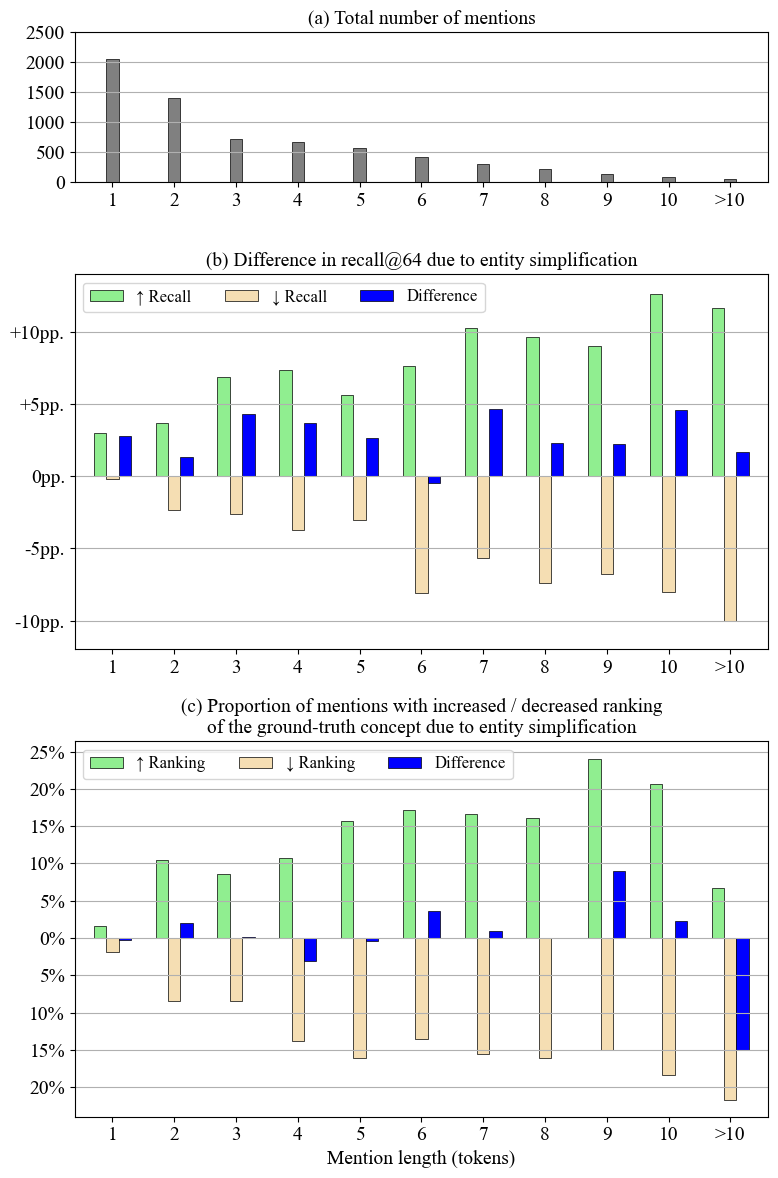

In [41]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager


fig, axs = plt.subplots(3, 1, figsize=(8,12), gridspec_kw={'height_ratios': [0.4, 1, 1]})
font_size_lg = 14
font_size_sm = 12

matplotlib.rcParams.update({'font.size': font_size_lg, 'font.family' : 'Times New Roman'})

width = 0.2

ax0 = axs[0]
ax0.bar(np.array(index), n_candidates, width=width, label='No. Mentions', color='grey', edgecolor='black', linewidth=0.5)
ax0.grid(axis='y')
ax0.set_title('(a) Total number of mentions', size=font_size_lg)
ax0.set_yticks(range(0,3000,500))

ax1 = axs[1]

ax1.grid(axis='y')

#ax.bar(np.array(index) - width, match_0, width=width, label='')
ax1.bar(np.array(index) - width, get_rel(match_any), width=width, label='↑ Recall', color='lightgreen', edgecolor='black', linewidth=0.5)
ax1.bar(np.array(index), get_rel(match_lost), width=width, label='↓ Recall', color='wheat', edgecolor='black', linewidth=0.5)
ax1.bar(np.array(index) + width, get_rel(np.array(match_any) + np.array(match_lost)), width=width, label='Difference', color='blue', edgecolor='black', linewidth=0.5)

y_range = np.arange(-0.1, 0.18, 0.05)
ax1.set_yticks(y_range)
ax1.set_yticklabels([f'{"+" if i > 0 else ""}{round(i * 100)}pp.' for i in y_range])
ax1.set_ylim(-0.12,0.14)
ax1.set_title('(b) Difference in recall@64 due to entity simplification', size=font_size_lg)
ax1.legend(loc='upper left', 
           ncol=3, fontsize=font_size_sm)    

ax2 = axs[2]
    
ax2.bar(np.array(index) - width, get_rel(better_ranking), width=width, label='↑ Ranking', color='lightgreen', edgecolor='black', linewidth=0.5)
ax2.bar(np.array(index), get_rel(worse_ranking), width=width, label='↓ Ranking', color='wheat', edgecolor='black', linewidth=0.5)
ax2.bar(np.array(index) + width, get_rel(np.array(better_ranking) + np.array(worse_ranking)), width=width, label='Difference', color='blue', edgecolor='black', linewidth=0.5)
    
y_range_2 = np.arange(-0.2,0.3,0.05)
ax2.set_yticks(y_range_2)
ax2.set_yticklabels([f'{"" if i > 0 else ""}{abs(round(i * 100))}%' for i in y_range_2])
 
ax2.legend(loc='upper left', ncol=3, fontsize=font_size_sm)
ax2.set_title('(c) Proportion of mentions with increased / decreased ranking\nof the ground-truth concept due to entity simplification', size=font_size_lg)
    
ax2.grid(axis='y')
ax2.set_xlabel('Mention length (tokens)')

for ax in axs:
    ax.set_xlim(axs[0].get_xlim())
    ax.set_xticks(index)
    ax.set_xticklabels(labels)

fig.tight_layout()
    
#plt.savefig('gain_vs_length.png', dpi=1200, bbox_inches='tight')
plt.show()